In [3]:
# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model
import shap

In [4]:
# reading input data
file_name = '/content/drive/MyDrive/AAM_data/perc_classification_homicides_popStandardized.csv'
df = pd.read_csv(file_name)
df = df.drop(columns=['TOTAL_EMPTY_HOUSES'])
print(df)

     POP_DENS_sqkm  LOW_INCOME_PERC  LOWMOD_INCOME_PERC  WHITE_POP_PERC  \
0          9365.67             0.60                0.74            0.01   
1          2827.45             0.14                0.25            0.05   
2          4580.80             0.30                0.41            0.04   
3         13079.89             0.15                0.28            0.53   
4         14412.00             0.06                0.16            0.55   
..             ...              ...                 ...             ...   
566        2545.37             0.22                0.48            0.28   
567        1689.03             0.10                0.22            0.09   
568        2638.81             0.51                0.55            0.19   
569         400.62             0.18                0.26            0.09   
570          15.29             0.00                0.00            0.27   

     BLACK_POP_PERC  O18_POP_PERC  IS_HOTSPOT  
0              0.92          0.70           1  
1  

In [5]:
# check for missing values
print(df.isna().sum())

POP_DENS_sqkm         0
LOW_INCOME_PERC       0
LOWMOD_INCOME_PERC    0
WHITE_POP_PERC        0
BLACK_POP_PERC        0
O18_POP_PERC          0
IS_HOTSPOT            0
dtype: int64


In [6]:
# investigating class imbalance
nb_of_hotspots = (df['IS_HOTSPOT'] == 1).sum()
nb_of_nonhotspots = len(df) - nb_of_hotspots


print(f'Number of Hotspots = {nb_of_hotspots}')
print(f'Number of Non-Hotspots = {nb_of_nonhotspots}')

Number of Hotspots = 96
Number of Non-Hotspots = 475


<Axes: >

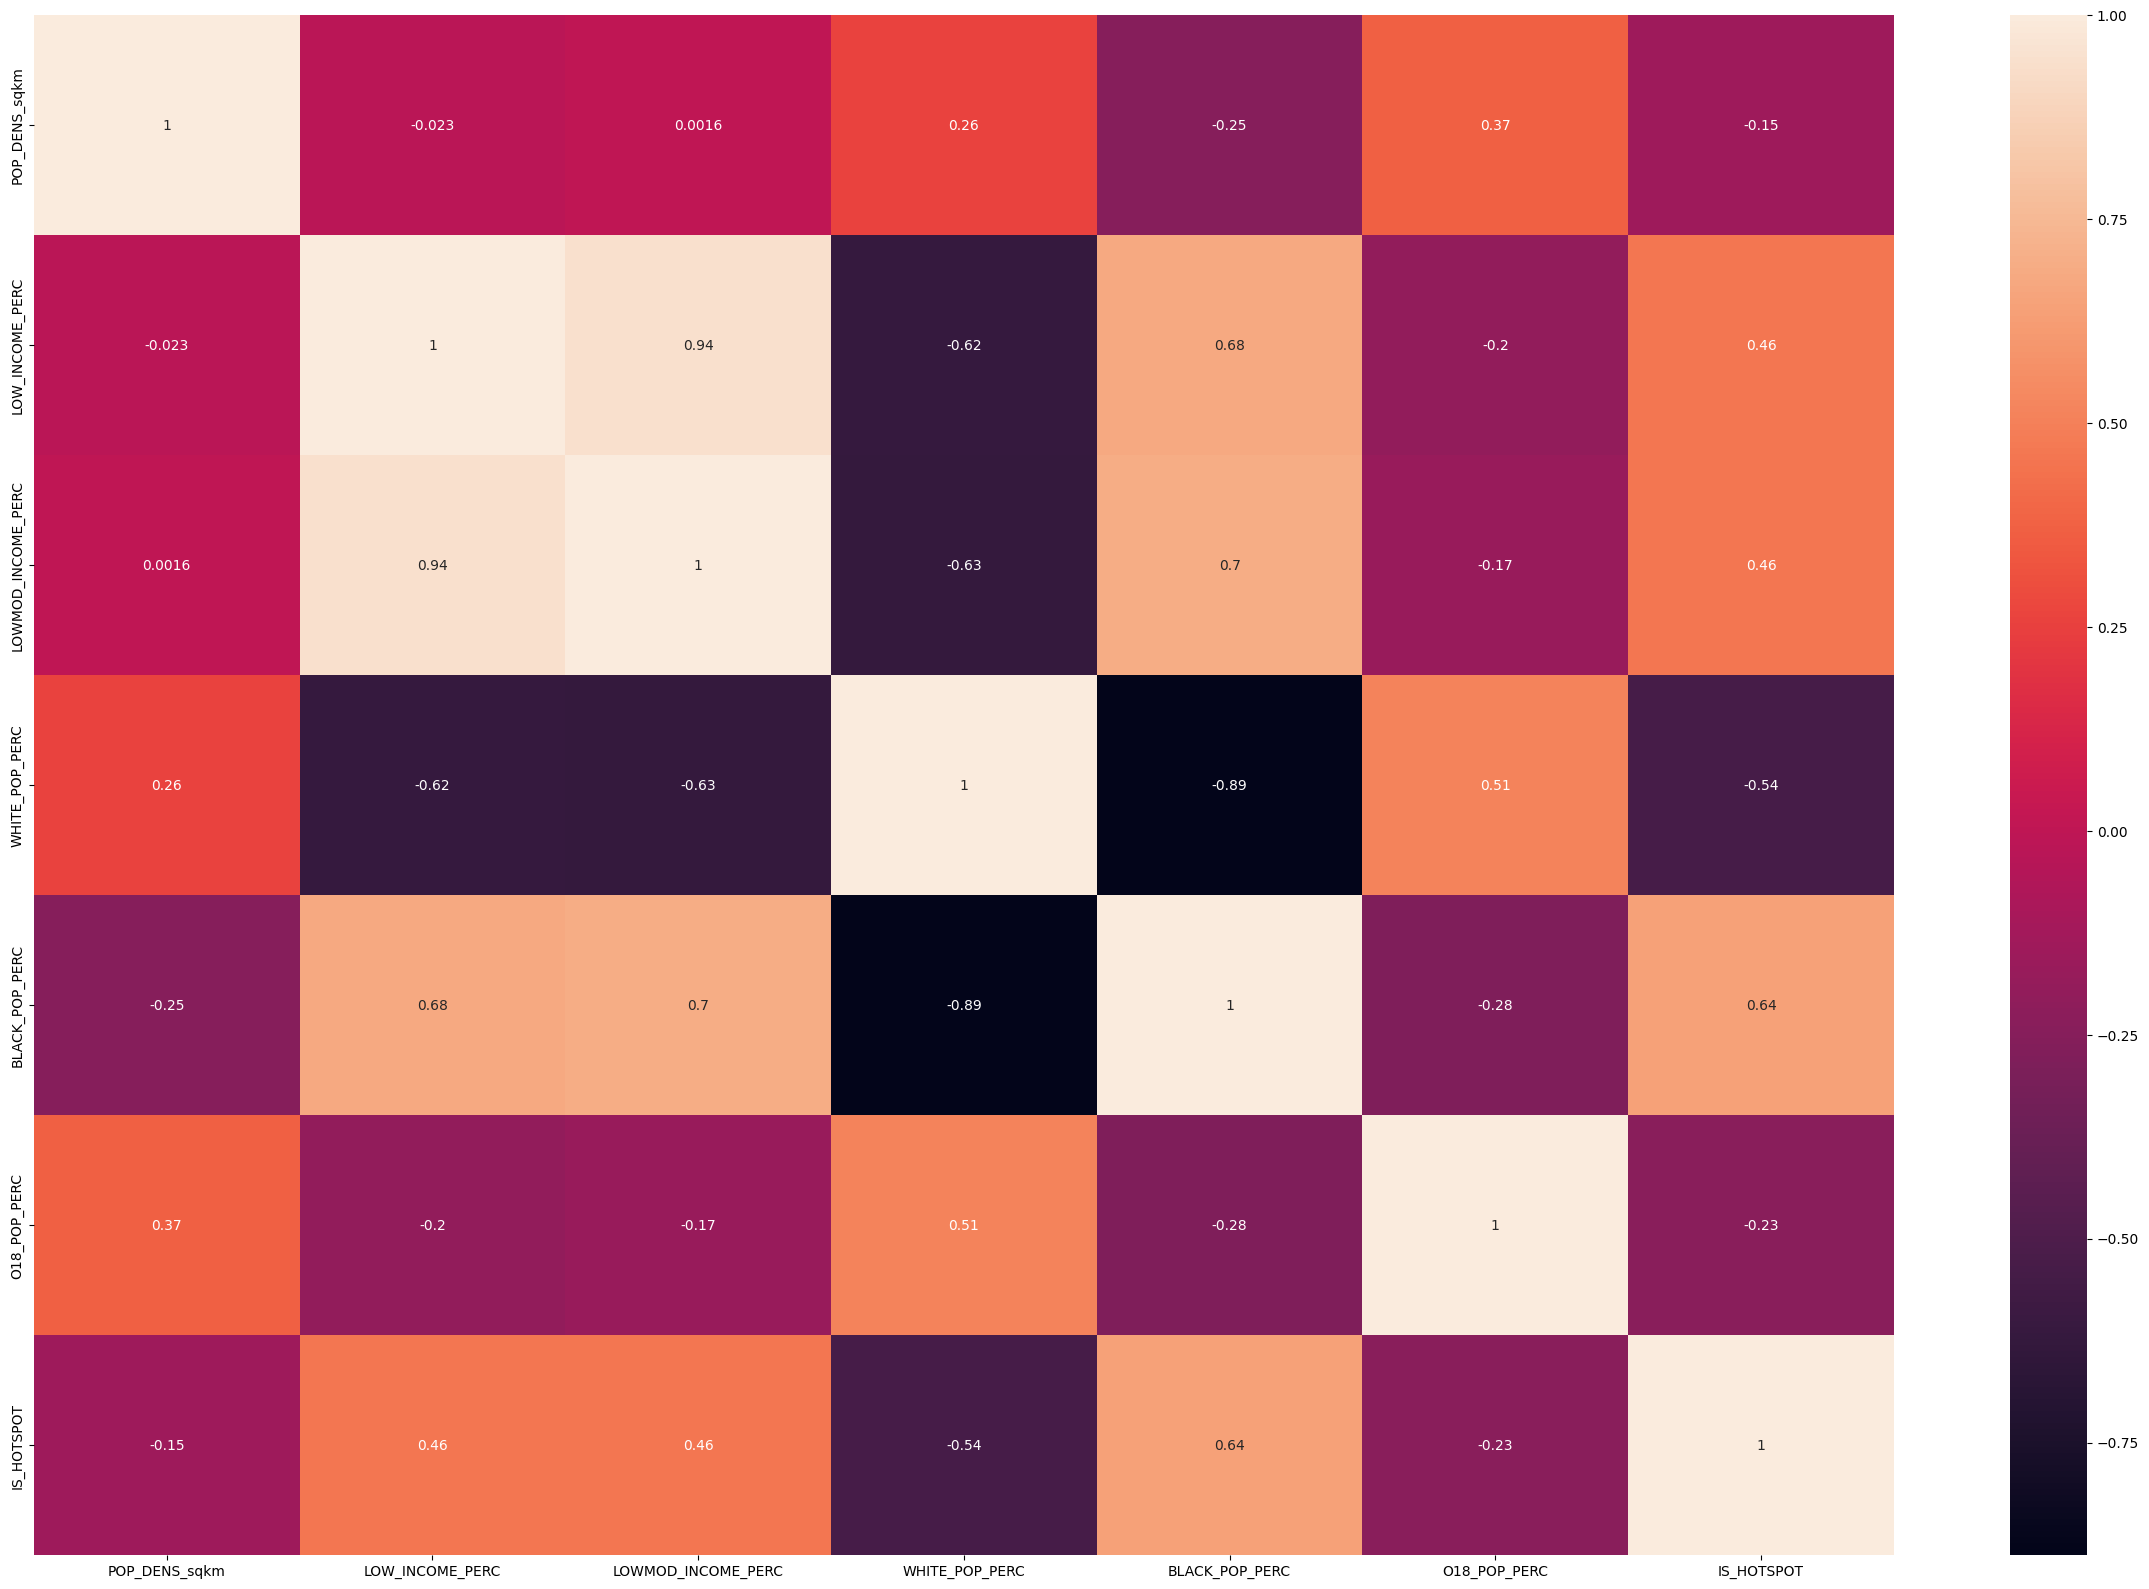

In [7]:
# correlation heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True)

In [8]:
# prepare features and target
X = df.drop("IS_HOTSPOT", axis=1)
y = df["IS_HOTSPOT"]

In [9]:
# Preprocessing (MinMax Scaling)
ct = make_column_transformer(
    (MinMaxScaler(), ["POP_DENS_sqkm", "LOW_INCOME_PERC", "LOWMOD_INCOME_PERC",
                      "WHITE_POP_PERC", "BLACK_POP_PERC", "O18_POP_PERC"])
)

In [10]:
# k-fold cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# storage for evaluation matrics
accuracies = []
precisions = []
recalls = []
f1_scores = []


=== Fold 1 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy: 0.939 | Precision: 0.810 | Recall: 0.850 | F1: 0.829
Confusion Matrix:
[[91  4]
 [ 3 17]]

SHAP Summary Plot for Fold 1


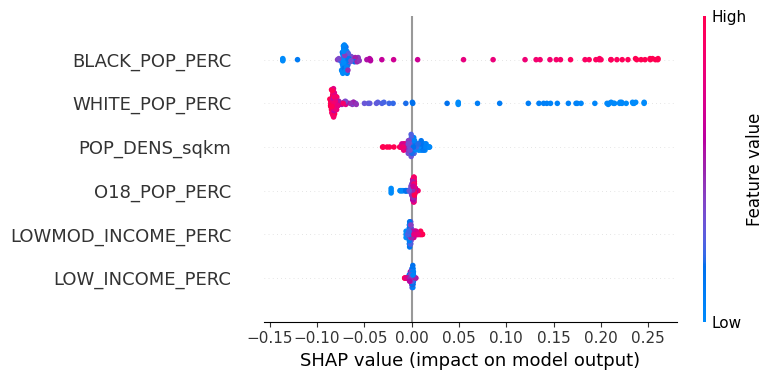


=== Fold 2 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.930 | Precision: 0.739 | Recall: 0.895 | F1: 0.810
Confusion Matrix:
[[89  6]
 [ 2 17]]

SHAP Summary Plot for Fold 2


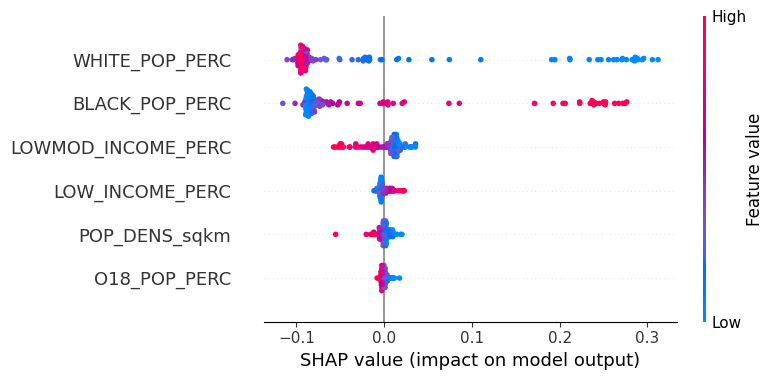


=== Fold 3 ===


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 0.895 | Precision: 0.652 | Recall: 0.789 | F1: 0.714
Confusion Matrix:
[[87  8]
 [ 4 15]]

SHAP Summary Plot for Fold 3


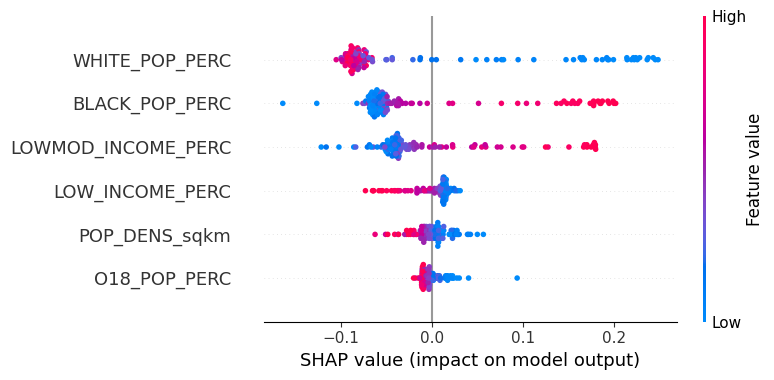


=== Fold 4 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.860 | Precision: 0.588 | Recall: 0.526 | F1: 0.556
Confusion Matrix:
[[88  7]
 [ 9 10]]

SHAP Summary Plot for Fold 4


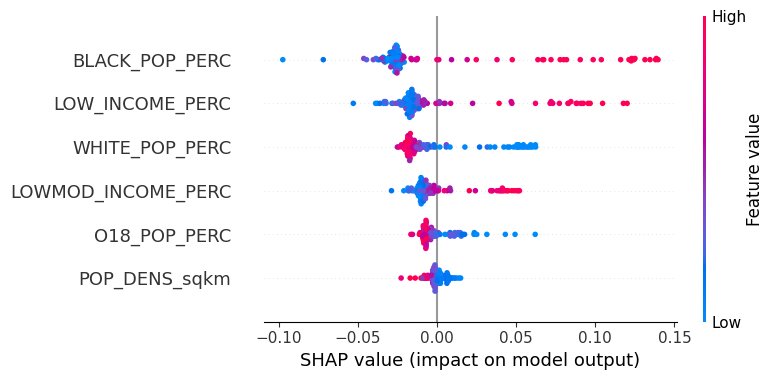


=== Fold 5 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.877 | Precision: 0.667 | Recall: 0.526 | F1: 0.588
Confusion Matrix:
[[90  5]
 [ 9 10]]

SHAP Summary Plot for Fold 5


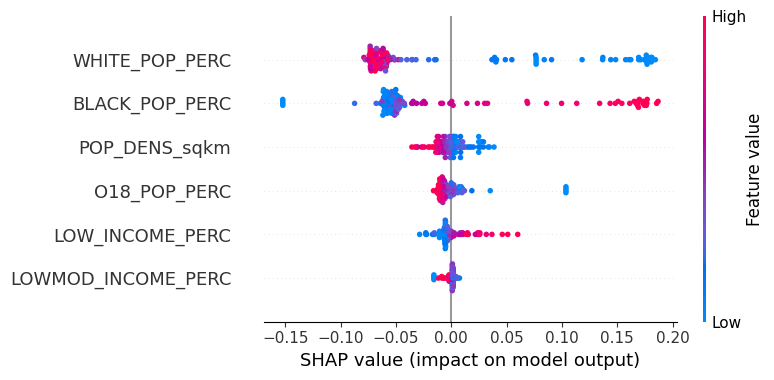

In [12]:
# cross-Validation Loop
fold = 1
for train_index, test_index in kf.split(X, y):
    print(f"\n=== Fold {fold} ===")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # preprocess
    ct.fit(X_train)
    X_train_normal = ct.transform(X_train)
    X_test_normal = ct.transform(X_test)

    # build ANN model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train model
    history = model.fit(X_train_normal, y_train, epochs=100, verbose=0)

    # predict on test set
    y_pred_probs = model.predict(X_test_normal)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # save metrics
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("Confusion Matrix:")
    print(cm)

    # shap graphic for each fold
    explainer = shap.Explainer(model, X_test_normal)
    shap_values = explainer(X_test_normal)
    print(f"\nSHAP Summary Plot for Fold {fold}")
    shap.summary_plot(shap_values, X_test_normal, feature_names=X.columns)

    fold += 1

In [13]:
# results
print("\n=== Cross-Validation Summary ===")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average F1 Score: {np.mean(f1_scores):.3f}")


=== Cross-Validation Summary ===
Average Accuracy: 0.900
Average Precision: 0.691
Average Recall: 0.717
Average F1 Score: 0.699
